In [1]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv
import shutil
import gc

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import math
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.freesurfer.utils import MakeAverageSubject
from nipype.interfaces.fsl import ExtractROI
from nipype.interfaces.fsl import Merge
from nipype.interfaces.fsl import TOPUP
from nipype.interfaces.fsl import ApplyTOPUP
from nipype.workflows.fmri.fsl import create_susan_smooth

from nilearn import input_data

%matplotlib inline

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects_ser.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
exp_list = ['ser','sim']

In [3]:
all_rois = {'ser':["lOFC_fill_ser", "mOFC_fill_ser"],'sim':["lOFC_fill_sim", "mOFC_fill_sim"]}

In [4]:
frames = np.arange(-1, 6) #number of frames to hold onto

In [5]:
##add a column to the timing file coding for the TR in which an event occured
def get_event_times(sub,exp):
    event_file = home_dir + 'data/' + sub + '/design/' + exp + '_state.csv'
    timing = pd.read_csv(event_file)
    timing =  timing.sort(['run','onset'])
    tr = 1.5
    for run in range(1,4):
        event_time = timing.loc[timing['run']==run,'onset'].values
        tr_index = map(lambda x: int(math.floor(x/tr)),event_time)
        timing.loc[timing['run']==run,'tr_index'] = tr_index
    
    return timing

In [15]:
def load_data(sub,exp, roi):
    all_data = {}
    for run in range(1,4):
        #data files
        mask_f = home_dir + 'data/' + sub + '/masks/' + roi + '.nii.gz'
        func_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + str(run) + '/unsmoothed_timeseries.nii.gz'
#         func_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/reg/epi/unsmoothed/run_' + str(run) + '/timeseries_xfm.nii.gz'

        if os.path.exists(func_f):
            #load data and detrend
            nifti_masker = input_data.NiftiMasker(mask_img = mask_f, standardize = True)
            fmri_masked = nifti_masker.fit_transform(func_f)
        
            all_data['run'+str(run)] = fmri_masked
    
    return all_data

In [7]:
##build concatenated X file for fitting
def build_data_file(in_tuple,all_data,timing,frame):
    X = []
    for run in range(1,4):
        run_idx = 'run'+str(run)
        if run_idx in all_data.keys():
            #get indices of events of interest and mask data
            event_indices = np.array([False]*all_data['run'+str(run)].shape[0])
            indices = np.array(timing[timing['run']==run]['tr_index'].values,dtype=int) + frame
            
             #deal with situation when scan is too short
            scan_dur = len(event_indices)
            if scan_dur <= indices[-1]:
                
                print str(in_tuple) + ' ' + str(run)
                
                #crop indices vector and take scans
                cropped_indices = [x for x in indices if x<scan_dur]                
                event_indices[cropped_indices] = True

                #Drop unused entries from the timing dataframe
                while len(cropped_indices) < len(indices):
                    cropped_indices.append(np.NaN)
                timing.loc[timing['run']==run,'tr_index'] = cropped_indices
                timing = timing.dropna()
                
            else:            
                event_indices[indices] = True
        
            fmri_masked = all_data[run_idx][event_indices,:]
            X.extend(fmri_masked)

    X = np.array(X) #convert to numpy array
    return X, timing

In [8]:
def run_decoding(in_tuple):
    
    sub, roi, exp = in_tuple
    
    all_data = load_data(sub,exp,roi)
    timing = get_event_times(sub,exp)
    
    scores = []
    for frame in frames:
        X,timing = build_data_file(in_tuple, all_data,timing,frame)

        #set up classifier
        classifier = LogisticRegression(penalty = 'l2', C=1.)
#         classifier = SVC(kernel = 'linear', C=1)
        cv = LeaveOneLabelOut(timing['run'].values-1)

        #convert labels to TF.
        cond_map = {'state':True,'not':False}            
        target = map(lambda x: cond_map[x], timing['condition'].values)

        res = cross_val_score(classifier, X, target, cv=cv, scoring = 'accuracy')
        scores.append(np.mean(res))
        
    return (scores,sub,roi,exp)

In [9]:
#check file sizes to make sure that the timing indices aren't longer than the run
def check_size(in_tuple):
    
    max_frames = 5
    sub,roi, exp = in_tuple
    
    timing = get_event_times(sub,exp)

    for run in range(1,4):
        
        func_f = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/reg/epi/unsmoothed/run_' + str(run) + '/timeseries_xfm.nii.gz'
        
        if os.path.exists(func_f):
            scan_dur = nib.load(func_f).shape[-1]

            indices = np.array(timing[timing['run']==run]['tr_index'].values,dtype=int)
            
            if (indices[-1] + max_frames) > scan_dur:
                print in_tuple
                print run        
        else:
            print func_f

In [10]:
in_tuples = []
for sub in sub_list:
    for exp in exp_list:
        rois = all_rois[exp]
        for roi in rois:
            in_tuples.append((sub,roi,exp))

In [16]:
pool = multiprocessing.Pool(processes = 16)
ouput = pool.map(run_decoding,in_tuples)
pool.terminate()
pool.join()

('fd_109', 'lOFC_fill_sim', 'sim') 2
('fd_109', 'lOFC_fill_sim', 'sim') 2
('fd_109', 'mOFC_fill_sim', 'sim') 2
('fd_109', 'mOFC_fill_sim', 'sim') 2


In [17]:
#organize output into dataframe
accuracy_df = {'sub':[],'exp':[],'roi':[],'tr':[],'accuracy':[]}
for o in ouput:
    scores, sub, roi, exp = o
    roi = roi[:-9]
    
    accuracy_df['sub'].extend(len(frames)*[sub])
    accuracy_df['exp'].extend(len(frames)*[exp])
    accuracy_df['roi'].extend(len(frames)*[roi])
    accuracy_df['tr'].extend(frames*1.5)
    accuracy_df['accuracy'].extend(scores)
    
accuracy_df = pd.DataFrame(accuracy_df)

In [184]:
# accuracy_df.groupby(['exp','roi','tr']).mean()

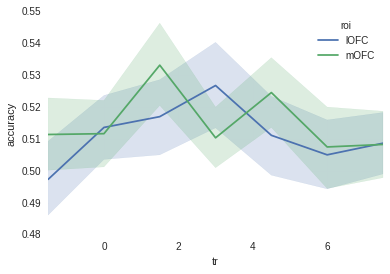

In [19]:
sns.tsplot(accuracy_df[accuracy_df['exp']=='ser'],unit='sub',time='tr',value='accuracy',condition='roi')

In [178]:
accuracy_df.to_csv('/home/iballard/fd/logistic.csv')

In [178]:
subj_file = home_dir + 'new_subs_temp.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
for sub in sub_list:
    for exp in ['sim','ser']:
        for run in range(1,4):
            file_path = '/home/iballard/fd/analysis/' + exp + '_8mm/' + sub + '/reg/epi/unsmoothed/run_' \
            + str(run) + '/timeseries_xfm.nii.gz'
            os.remove(file_path)